##Loading Data


In [ ]:
!pip install -U finance-datareader

import FinanceDataReader as fdr
import pandas_datareader.data as pdr 
import numpy as np
import pandas as pd

!pip install pandas_datareader
!pip install pmdarima

import os 

from sklearn.model_selection import train_test_split 
from sklearn.metrics import r2_score 

import matplotlib.pyplot as plt
import matplotlib 
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima 

import seaborn as sns 

plt.style.use('seaborn-whitegrid')
#sns.set_style("white")
%matplotlib inline

import itertools

     |████████████████████████████████| 48 kB 2.9 MB/s 
     |████████████████████████████████| 1.4 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 41.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
# Loading prices of Samsung Electronics from last 3 years
df = fdr.DataReader('005930', '2019-03-04', '2022-03-04')
df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2019-03-04,46000,46100,44800,44850,12926539,-0.005543
2019-03-05,44600,45100,44150,44250,10612405,-0.013378
2019-03-06,44000,44300,43700,44000,10202544,-0.005650
2019-03-07,43400,44950,43400,44450,11049749,0.010227
2019-03-08,44450,44800,43800,43800,7729069,-0.014623


In [ ]:
df.tail()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2022-02-25,72100,72600,71900,71900,13168484,0.005594
2022-02-28,71100,72100,71000,72100,17781783,0.002782
2022-03-02,72300,72400,71500,71700,12481430,-0.005548
2022-03-03,72300,73100,72200,72900,13232638,0.016736
2022-03-04,72700,72700,71200,71500,13409634,-0.019204


In [ ]:
df.shape

(744, 6)

## Data preprocessing (MinMaxScaler)

In [ ]:
def MinMaxScaler(data):
    """changing the data range from 0~1 using minimum and maximum value"""
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    #add a very small value(1e-7) to prevent error caused by divide by 0
    return numerator / (denominator + 1e-7)

In [ ]:
dfx = df[['Open','High','Low','Volume', 'Close']]
dfx = MinMaxScaler(dfx)
dfy = dfx[['Close']]
dfx = dfx[['Open','High','Low','Volume']]

In [ ]:
dfx

,Open,High,Low,Volume
Date,,,,
2019-03-04,0.095918,0.073973,0.081192,0.099186
2019-03-05,0.067347,0.055708,0.067831,0.072246
2019-03-06,0.055102,0.041096,0.058582,0.067474
2019-03-07,0.042857,0.052968,0.052415,0.077337
2019-03-08,0.064286,0.050228,0.060637,0.038679
...,...,...,...,...
2022-02-25,0.628571,0.557991,0.638232,0.102002
2022-02-28,0.608163,0.548858,0.619733,0.155708
2022-03-02,0.632653,0.554338,0.630010,0.094004


In [ ]:
dfx.describe()

,Open,High,Low,Volume
count,744.000000,744.000000,744.000000,744.000000
mean,0.437169,0.388251,0.436904,0.150027
std,0.292614,0.263532,0.292878,0.107176
min,0.000000,0.000000,0.000000,0.000000
25%,0.165306,0.141324,0.163412,0.079588
50%,0.368367,0.325114,0.367934,0.125094
75%,0.733163,0.651142,0.734841,0.191295
max,1.000000,1.000000,1.000000,1.000000


In [ ]:
dfy.head()

,Close
Date,
2019-03-04,0.073293
2019-03-05,0.061245
2019-03-06,0.056225
2019-03-07,0.065261
2019-03-08,0.052209


In [ ]:
# 두 데이터를 리스트 형태로 저장
X = dfx.values.tolist()
y = dfy.values.tolist()

In [ ]:
X[:5]

[[0.09591836734674303,
  0.07397260273959091,
  0.08119218910569127,
  0.09918560083472276],
 [0.06734693877537276,
  0.055707762556975876,
  0.06783144912627373,
  0.07224562951051035],
 [0.05510204081621407,
  0.041095890410883844,
  0.05858170606360004,
  0.06747423615692191],
 [0.04285714285705539,
  0.052968036529583616,
  0.052415210688484246,
  0.07733696597538937],
 [0.06428571428558309,
  0.05022831050219136,
  0.060637204521971966,
  0.038679297933311575]]

In [ ]:
y[:5]

[[0.07329317269061587],
 [0.061244979919555735],
 [0.05622489959828067],
 [0.06526104417657579],
 [0.052208835341260626]]

##2-3. Data Preprocessing( Predicting ending price of next day using 10 days of OHLVC data
)

In [ ]:
window_size = 10

In [ ]:
data_X = []
data_y = []
for i in range(len(y) - window_size):
    _X = X[i : i + window_size] # Ending price for next day is not included
    _y = y[i + window_size]     # ending price for next day
    data_X.append(_X)
    data_y.append(_y)
print(_X, "->", _y)

[[0.6877551020394127, 0.6127853881267347, 0.6916752312421548, 0.10708834585884078], [0.6795918367333069, 0.5981735159806426, 0.6752312435751794, 0.06653921484146737], [0.6510204081619367, 0.5890410958893351, 0.6526207605330882, 0.07081735819959016], [0.6469387755088838, 0.5726027397249815, 0.656731757449832, 0.08481918540153228], [0.6632653061210954, 0.5799086757980275, 0.656731757449832, 0.06974921642866831], [0.6326530612231986, 0.552511415524105, 0.625899280574253, 0.1321629660732244], [0.6285714285701458, 0.5579908675788895, 0.6382322713244846, 0.10200220149917719], [0.6081632653048813, 0.548858447487582, 0.6197327851991372, 0.15570788266112276], [0.6326530612231986, 0.5543378995423665, 0.6300102774909969, 0.09400386818823434], [0.6326530612231986, 0.567123287670197, 0.6443987666996004, 0.10274904974579277]] -> [0.6084337349385373]


For example, this is the first sample of data_x



In [ ]:
#OHLVC data for 10 days
data_X[0]

[[0.09591836734674303,
  0.07397260273959091,
  0.08119218910569127,
  0.09918560083472276],
 [0.06734693877537276,
  0.055707762556975876,
  0.06783144912627373,
  0.07224562951051035],
 [0.05510204081621407,
  0.041095890410883844,
  0.05858170606360004,
  0.06747423615692191],
 [0.04285714285705539,
  0.052968036529583616,
  0.052415210688484246,
  0.07733696597538937],
 [0.06428571428558309,
  0.05022831050219136,
  0.060637204521971966,
  0.038679297933311575],
 [0.06326530612231987,
  0.0438356164382761,
  0.05755395683441407,
  0.07346802104399816],
 [0.06122448979579342,
  0.052968036529583616,
  0.06783144912627373,
  0.08178666999396006],
 [0.060204081632530194,
  0.0438356164382761,
  0.05858170606360004,
  0.04309461298594869],
 [0.04897959183663474,
  0.041095890410883844,
  0.05549845837604214,
  0.15870414646411912],
 [0.05102040816316118,
  0.04018264840175309,
  0.05858170606360004,
  0.1444433426419474]]

This is the first sample of data_y.

In [ ]:
# the answer for data_y[0] when data_x[0] is inputted
data_y[0]

[0.0502008032127506]

 If we put this value on a RNN model, RNN would be performed 10 times. 
In this model, we would get input from $x_{0}$부터 $x_{9}$ and the RNN will predict the ending price of the next day.

##2-4. split training and test data

In [ ]:
print('Size of entire data :', len(data_X), len(data_y))

Size of entire data : 734 734


Split data into training and testing data. The ratio between train and test should be 7:3


In [ ]:
train_size = int(len(data_y) * 0.7)
train_X = np.array(data_X[0 : train_size])
train_y = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
test_X = np.array(data_X[train_size : len(data_X)])
test_y = np.array(data_y[train_size : len(data_y)])

In [ ]:
print('Train data size :', train_X.shape, train_y.shape)
print('Test data size :', test_X.shape, test_y.shape)

Train data size : (513, 10, 4) (513, 1)
Test data size : (221, 10, 4) (221, 1)




```
# 코드로 형식 지정됨
```

##2-5. Learning Model


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [ ]:
model = Sequential()
model.add(LSTM(units=20, activation='relu', return_sequences=True, input_shape=(10, 4)))
model.add(Dropout(0.1))
model.add(LSTM(units=20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 20)            2000      
                                                                 
 dropout (Dropout)           (None, 10, 20)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 5,301
Trainable params: 5,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_X, train_y, epochs=70, batch_size=30)
pred_y = model.predict(test_X)

Epoch 1/70
18/18 [==============================] - 5s 34ms/step - loss: 0.1498
Epoch 2/70
18/18 [==============================] - 1s 33ms/step - loss: 0.0791
Epoch 3/70
18/18 [==============================] - 1s 34ms/step - loss: 0.0271
Epoch 4/70
18/18 [==============================] - 1s 35ms/step - loss: 0.0138
Epoch 5/70
18/18 [==============================] - 1s 34ms/step - loss: 0.0080
Epoch 6/70
18/18 [==============================] - 1s 33ms/step - loss: 0.0096
Epoch 7/70
18/18 [==============================] - 1s 32ms/step - loss: 0.0065
Epoch 8/70
18/18 [==============================] - 1s 34ms/step - loss: 0.0064
Epoch 9/70
18/18 [==============================] - 1s 33ms/step - loss: 0.0077
Epoch 10/70
18/18 [==============================] - 1s 34ms/step - loss: 0.0070
Epoch 11/70
18/18 [==============================] - 1s 33ms/step - loss: 0.0072
Epoch 12/70
18/18 [==============================] - 1s 33ms/step - loss: 0.0068
Epoch 13/70
18/18 [==================

In [ ]:
test_y.shape

(221, 1)

In [ ]:
pred_y = model.predict(test_X)

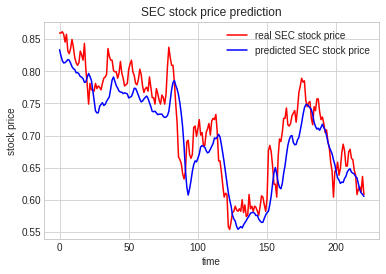

Tomorrow's SEC price : [71159.14202518] KRW


In [ ]:
# Visualising the results
plt.figure()
plt.plot(test_y, color='red', label='real SEC stock price')
plt.plot(pred_y, color='blue', label='predicted SEC stock price')
plt.title('SEC stock price prediction')
plt.xlabel('time')
plt.ylabel('stock price')
plt.legend()
plt.show()

# raw_df.close[-1] : dfy.close[-1] = x : pred_y[-1]
print("Tomorrow's SEC price :", df.Close[-1] * pred_y[-1] / dfy.Close[-1], 'KRW')

In [ ]:
from sklearn import metrics

print("MAE: ", metrics.mean_absolute_error(test_y,pred_y))
print("MSE: ", metrics.mean_squared_error(test_y,pred_y))

#print("MAE: ", metrics.mean_absolute_error(data2.visitors ,pred_value))
#print("MSE: ", metrics.mean_squared_error(data2.visitors,pred_value))

MAE:  0.03157882079845485
MSE:  0.0014738897149570056


In [ ]:
test_y

array([[0.85943775],
       [0.85943775],
       [0.86144578],
       [0.85742972],
       [0.84538153],
       [0.85742972],
       [0.8313253 ],
       [0.82730924],
       [0.83534137],
       [0.84939759],
       [0.8373494 ],
       [0.82128514],
       [0.81325301],
       [0.80923695],
       [0.81325301],
       [0.8313253 ],
       [0.8253012 ],
       [0.81726908],
       [0.84337349],
       [0.80321285],
       [0.77911647],
       [0.74899598],
       [0.7811245 ],
       [0.77108434],
       [0.77108434],
       [0.76907631],
       [0.7811245 ],
       [0.77309237],
       [0.77710843],
       [0.7751004 ],
       [0.77108434],
       [0.7811245 ],
       [0.78915663],
       [0.79116466],
       [0.79518072],
       [0.83534137],
       [0.82329317],
       [0.81726908],
       [0.81726908],
       [0.80120482],
       [0.79919679],
       [0.79919679],
       [0.78915663],
       [0.79718876],
       [0.81526104],
       [0.79718876],
       [0.78915663],
       [0.777

In [ ]:
test_y.shape

(221, 1)

In [ ]:
dfy

,Close
Date,
2019-03-04,0.073293
2019-03-05,0.061245
2019-03-06,0.056225
2019-03-07,0.065261
2019-03-08,0.052209
...,...
2022-02-25,0.616466
2022-02-28,0.620482
2022-03-02,0.612450


In [ ]:
len(data_y)
data_y

[[0.0502008032127506],
 [0.05421686746977065],
 [0.057228915662535684],
 [0.09337349397571612],
 [0.10742971887528628],
 [0.08634538152593103],
 [0.08132530120465598],
 [0.08333333333316599],
 [0.07329317269061587],
 [0.06927710843359583],
 [0.07730923694763592],
 [0.09136546184720609],
 [0.1084337349395413],
 [0.11546184738932638],
 [0.11345381526081635],
 [0.10943775100379631],
 [0.10943775100379631],
 [0.11044176706805132],
 [0.10140562248975621],
 [0.11345381526081635],
 [0.1174698795178364],
 [0.12148594377485646],
 [0.1174698795178364],
 [0.08835341365444106],
 [0.08232931726891099],
 [0.08333333333316599],
 [0.08032128514040096],
 [0.07128514056210586],
 [0.06927710843359583],
 [0.07329317269061587],
 [0.0993975903612462],
 [0.09337349397571612],
 [0.09437751003997112],
 [0.08232931726891099],
 [0.07329317269061587],
 [0.061244979919555735],
 [0.0251004016063753],
 [0.03413654618467041],
 [0.02911646586339535],
 [0.02911646586339535],
 [0.027108433734885324],
 [0.007028112449785

In [ ]:
data= dfy

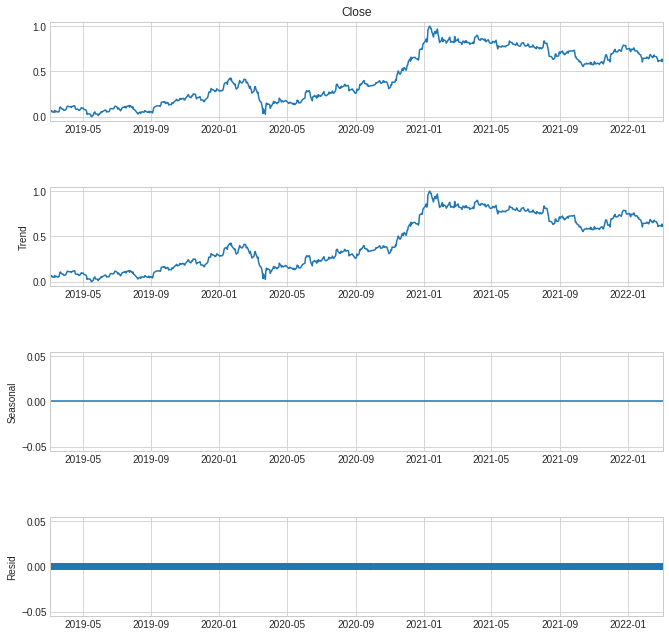

In [ ]:
decomposition = sm.tsa.seasonal_decompose(data['Close'], model='additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.30, shuffle=False)

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


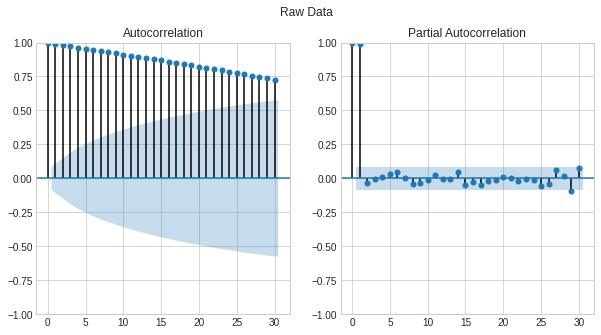

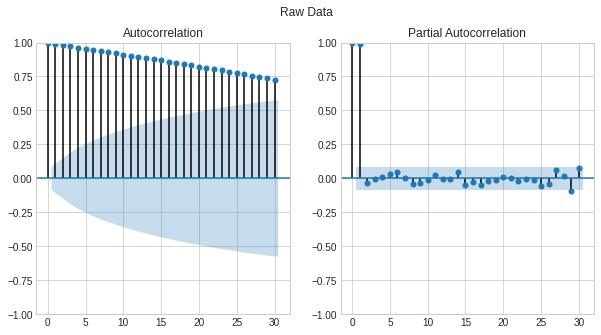

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.suptitle("Raw Data")
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1])

In [ ]:
# Differencing 

diff_train_data = train_data.copy()
diff_train_data = diff_train_data['Close'].diff()
diff_train_data = diff_train_data.dropna()
print('###### Raw Data ######')
print(train_data)
print('### Differenced Data ###')
print(diff_train_data)

###### Raw Data ######
               Close
Date                
2019-03-04  0.073293
2019-03-05  0.061245
2019-03-06  0.056225
2019-03-07  0.065261
2019-03-08  0.052209
...              ...
2021-04-01  0.837349
2021-04-02  0.875502
2021-04-05  0.887550
2021-04-06  0.899598
2021-04-07  0.891566

[520 rows x 1 columns]
### Differenced Data ###
Date
2019-03-05   -0.012048
2019-03-06   -0.005020
2019-03-07    0.009036
2019-03-08   -0.013052
2019-03-11   -0.003012
                ...   
2021-04-01    0.030120
2021-04-02    0.038153
2021-04-05    0.012048
2021-04-06    0.012048
2021-04-07   -0.008032
Name: Close, Length: 519, dtype: float64


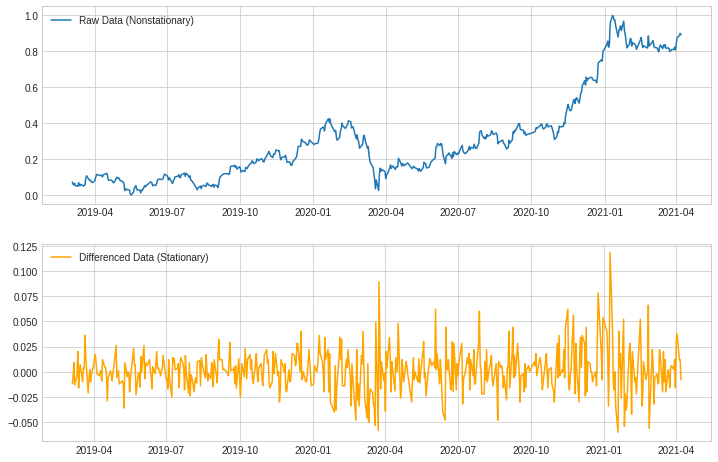

In [ ]:
#Differenced data plot
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_data['Close'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train_data, 'orange')
plt.legend(['Differenced Data (Stationary)'])
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


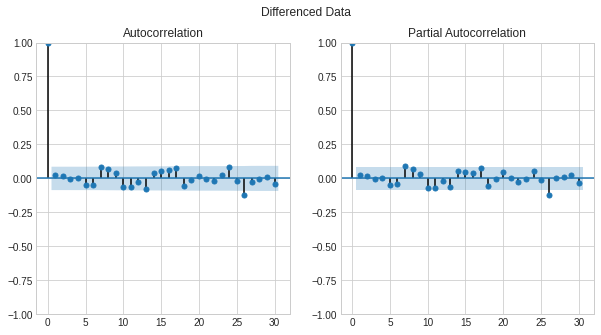

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Differenced Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1]);

In [ ]:
# 3.4.3 Diagnosis Check- auto_arima

auto_arima_model = auto_arima(train_data, start_p=1, start_q=1,
                              max_p=3, max_q=3, m=12, seasonal=True,
                              d=1, D=1,
                              max_P=3, max_Q=3,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True, 
                              stepwise=False)

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-2110.491, Time=0.09 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=1.34 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=6.08 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=inf, Time=9.34 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=-2291.372, Time=0.33 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=2.57 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=2.84 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=inf, Time=18.99 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-2351.202, Time=1.79 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=4.84 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=5.17 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=inf, Time=11.71 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=-2362.974, Time=2.35 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=8.14 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=inf, Time=11.57 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=

In [ ]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  520
Model:             SARIMAX(0, 1, 0)x(3, 1, 0, 12)   Log Likelihood                1185.487
Date:                            Fri, 22 Apr 2022   AIC                          -2362.974
Time:                                    16:18:34   BIC                          -2346.060
Sample:                                         0   HQIC                         -2356.341
                                            - 520                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7991      0.037    -21.436      0.000      -0.872      -0.726
ar.S.L24      -0.4658      0.046    -10.041      0.000      -0.557      -0.375
ar.S.L36      -0.1664      0.042     -3.987      0.000      -0.248      -0.085
sigma2         0.0005   2.55e-05     20.996      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                66.05
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               3.72   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
# use Model to Forecast-auto_arima 
prediction = auto_arima_model.predict(len(test_data), return_conf_int=True)
predicted_value_Arima = prediction[0]
prediction_ub = prediction[1][:,0]
predicted_lb = prediction[1][:,1]
predict_index_Arima = list(test_data.index)
r2 = r2_score(test_data, predicted_value_Arima)

ValueError: ignored

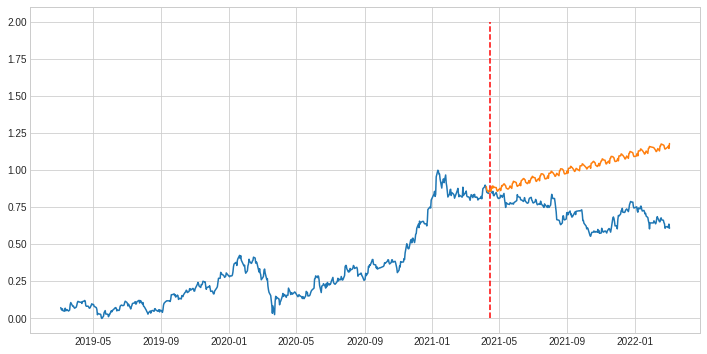

In [ ]:
fig, ax = plt.subplots(figsize= (12,6))
ax.plot(data.index, data)
ax.vlines(pd.to_datetime('2021-04-15'), 0, 2, linestyle='--',
         color='r', label='Start of Forecast')
ax.plot(predict_index_Arima, predicted_value_Arima, label='Prediction')
ax.fill_between(predict_index_Arima, prediction_ub, predicted_lb, color='grey', alpha=1, label='interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA({auto_arima_model.order, auto_arima_model.seasonal_order}) prediction results: {round(r2,2)}(r2 score)' )

In [ ]:
print("MAE: ", metrics.mean_absolute_error(test_data,predicted_value_Arima))
print("MSE: ", metrics.mean_squared_error(test_data,predicted_value_Arima))

MAE:  0.294975632912886
MSE:  0.11155655104868727


In [ ]:
# Diagnosis Check - SARIMA 

print('Examples of parameter combinations for Seasonal ARIMA...')
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

aic=[]
params=[]
for i in pdq: 
  for j in seasonal_pdq:
    try:
      model = SARIMAX(train_data.values, ordr=(i), seasonal_order =(j))
      model_fit = model.fit()
      print(f'SARIMA: {i}{j} >> AIC : {round(model_fit.aic,2)}')
      aic.append(round(model_fit.aic,2))
      params.append((i,j))
    except:
      continue

Examples of parameter combinations for Seasonal ARIMA...
SARIMA: (0, 1, 0)(0, 1, 0, 12) >> AIC : -2131.07
SARIMA: (0, 1, 0)(0, 1, 1, 12) >> AIC : -2440.83


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (0, 1, 0)(0, 1, 2, 12) >> AIC : -2444.33
SARIMA: (0, 1, 0)(1, 1, 0, 12) >> AIC : -2302.55
SARIMA: (0, 1, 0)(1, 1, 1, 12) >> AIC : -2438.92
SARIMA: (0, 1, 0)(1, 1, 2, 12) >> AIC : -2442.43
SARIMA: (0, 1, 0)(2, 1, 0, 12) >> AIC : -2359.29


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (0, 1, 0)(2, 1, 1, 12) >> AIC : -2442.75


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (0, 1, 0)(2, 1, 2, 12) >> AIC : -2440.31
SARIMA: (0, 1, 1)(0, 1, 0, 12) >> AIC : -2131.07
SARIMA: (0, 1, 1)(0, 1, 1, 12) >> AIC : -2440.83


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (0, 1, 1)(0, 1, 2, 12) >> AIC : -2444.33
SARIMA: (0, 1, 1)(1, 1, 0, 12) >> AIC : -2302.55
SARIMA: (0, 1, 1)(1, 1, 1, 12) >> AIC : -2438.92
SARIMA: (0, 1, 1)(1, 1, 2, 12) >> AIC : -2442.43
SARIMA: (0, 1, 1)(2, 1, 0, 12) >> AIC : -2359.29


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (0, 1, 1)(2, 1, 1, 12) >> AIC : -2442.75


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (0, 1, 1)(2, 1, 2, 12) >> AIC : -2440.31
SARIMA: (0, 1, 2)(0, 1, 0, 12) >> AIC : -2131.07
SARIMA: (0, 1, 2)(0, 1, 1, 12) >> AIC : -2440.83


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (0, 1, 2)(0, 1, 2, 12) >> AIC : -2444.33
SARIMA: (0, 1, 2)(1, 1, 0, 12) >> AIC : -2302.55
SARIMA: (0, 1, 2)(1, 1, 1, 12) >> AIC : -2438.92
SARIMA: (0, 1, 2)(1, 1, 2, 12) >> AIC : -2442.43
SARIMA: (0, 1, 2)(2, 1, 0, 12) >> AIC : -2359.29


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (0, 1, 2)(2, 1, 1, 12) >> AIC : -2442.75


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (0, 1, 2)(2, 1, 2, 12) >> AIC : -2440.31
SARIMA: (1, 1, 0)(0, 1, 0, 12) >> AIC : -2131.07
SARIMA: (1, 1, 0)(0, 1, 1, 12) >> AIC : -2440.83


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (1, 1, 0)(0, 1, 2, 12) >> AIC : -2444.33
SARIMA: (1, 1, 0)(1, 1, 0, 12) >> AIC : -2302.55
SARIMA: (1, 1, 0)(1, 1, 1, 12) >> AIC : -2438.92
SARIMA: (1, 1, 0)(1, 1, 2, 12) >> AIC : -2442.43
SARIMA: (1, 1, 0)(2, 1, 0, 12) >> AIC : -2359.29


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (1, 1, 0)(2, 1, 1, 12) >> AIC : -2442.75


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (1, 1, 0)(2, 1, 2, 12) >> AIC : -2440.31
SARIMA: (1, 1, 1)(0, 1, 0, 12) >> AIC : -2131.07
SARIMA: (1, 1, 1)(0, 1, 1, 12) >> AIC : -2440.83


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (1, 1, 1)(0, 1, 2, 12) >> AIC : -2444.33
SARIMA: (1, 1, 1)(1, 1, 0, 12) >> AIC : -2302.55
SARIMA: (1, 1, 1)(1, 1, 1, 12) >> AIC : -2438.92
SARIMA: (1, 1, 1)(1, 1, 2, 12) >> AIC : -2442.43
SARIMA: (1, 1, 1)(2, 1, 0, 12) >> AIC : -2359.29


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (1, 1, 1)(2, 1, 1, 12) >> AIC : -2442.75


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (1, 1, 1)(2, 1, 2, 12) >> AIC : -2440.31
SARIMA: (1, 1, 2)(0, 1, 0, 12) >> AIC : -2131.07
SARIMA: (1, 1, 2)(0, 1, 1, 12) >> AIC : -2440.83


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (1, 1, 2)(0, 1, 2, 12) >> AIC : -2444.33
SARIMA: (1, 1, 2)(1, 1, 0, 12) >> AIC : -2302.55
SARIMA: (1, 1, 2)(1, 1, 1, 12) >> AIC : -2438.92
SARIMA: (1, 1, 2)(1, 1, 2, 12) >> AIC : -2442.43
SARIMA: (1, 1, 2)(2, 1, 0, 12) >> AIC : -2359.29


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (1, 1, 2)(2, 1, 1, 12) >> AIC : -2442.75


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (1, 1, 2)(2, 1, 2, 12) >> AIC : -2440.31
SARIMA: (2, 1, 0)(0, 1, 0, 12) >> AIC : -2131.07
SARIMA: (2, 1, 0)(0, 1, 1, 12) >> AIC : -2440.83


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (2, 1, 0)(0, 1, 2, 12) >> AIC : -2444.33
SARIMA: (2, 1, 0)(1, 1, 0, 12) >> AIC : -2302.55
SARIMA: (2, 1, 0)(1, 1, 1, 12) >> AIC : -2438.92
SARIMA: (2, 1, 0)(1, 1, 2, 12) >> AIC : -2442.43
SARIMA: (2, 1, 0)(2, 1, 0, 12) >> AIC : -2359.29


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (2, 1, 0)(2, 1, 1, 12) >> AIC : -2442.75


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (2, 1, 0)(2, 1, 2, 12) >> AIC : -2440.31
SARIMA: (2, 1, 1)(0, 1, 0, 12) >> AIC : -2131.07
SARIMA: (2, 1, 1)(0, 1, 1, 12) >> AIC : -2440.83


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (2, 1, 1)(0, 1, 2, 12) >> AIC : -2444.33
SARIMA: (2, 1, 1)(1, 1, 0, 12) >> AIC : -2302.55
SARIMA: (2, 1, 1)(1, 1, 1, 12) >> AIC : -2438.92
SARIMA: (2, 1, 1)(1, 1, 2, 12) >> AIC : -2442.43
SARIMA: (2, 1, 1)(2, 1, 0, 12) >> AIC : -2359.29


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (2, 1, 1)(2, 1, 1, 12) >> AIC : -2442.75


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (2, 1, 1)(2, 1, 2, 12) >> AIC : -2440.31
SARIMA: (2, 1, 2)(0, 1, 0, 12) >> AIC : -2131.07
SARIMA: (2, 1, 2)(0, 1, 1, 12) >> AIC : -2440.83


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (2, 1, 2)(0, 1, 2, 12) >> AIC : -2444.33
SARIMA: (2, 1, 2)(1, 1, 0, 12) >> AIC : -2302.55
SARIMA: (2, 1, 2)(1, 1, 1, 12) >> AIC : -2438.92
SARIMA: (2, 1, 2)(1, 1, 2, 12) >> AIC : -2442.43
SARIMA: (2, 1, 2)(2, 1, 0, 12) >> AIC : -2359.29


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (2, 1, 2)(2, 1, 1, 12) >> AIC : -2442.75


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


SARIMA: (2, 1, 2)(2, 1, 2, 12) >> AIC : -2440.31


In [ ]:
# Search optimal parameters

optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[(((0, 1, 0), (0, 1, 2, 12)), -2444.33),
 (((0, 1, 1), (0, 1, 2, 12)), -2444.33),
 (((0, 1, 2), (0, 1, 2, 12)), -2444.33),
 (((1, 1, 0), (0, 1, 2, 12)), -2444.33),
 (((1, 1, 1), (0, 1, 2, 12)), -2444.33),
 (((1, 1, 2), (0, 1, 2, 12)), -2444.33),
 (((2, 1, 0), (0, 1, 2, 12)), -2444.33),
 (((2, 1, 1), (0, 1, 2, 12)), -2444.33),
 (((2, 1, 2), (0, 1, 2, 12)), -2444.33)]

In [ ]:
model_opt = SARIMAX(train_data.values, order=optimal[0][0][0], seasonal_order = optimal [0][0][1])
model_opt_fit = model_opt.fit()

model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  520
Model:             SARIMAX(0, 1, 0)x(0, 1, [1, 2], 12)   Log Likelihood                1223.640
Date:                                 Fri, 22 Apr 2022   AIC                          -2441.279
Time:                                         16:23:51   BIC                          -2428.594
Sample:                                              0   HQIC                         -2436.304
                                                 - 520                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.9970      0.037    -26.986      0.000      -1.069      -0.925
ma.S.L24       0.0585      0.040      1.477      0.140      -0.019       0.136
sigma2         0.0004   1.92e-05     23.144      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               142.33
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               3.75   Skew:                             0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#use Model to Forecast -SARIMA 
prediction = model_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
prediction_ub = prediction.conf_int()[:0]
predicted_lb = prediction.conf_int()[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)


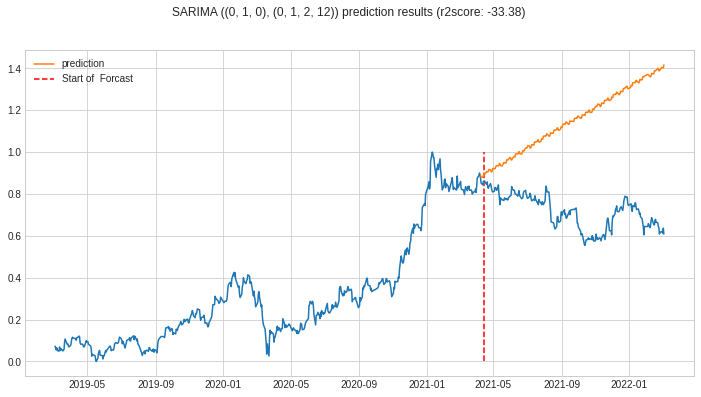

In [ ]:
fig, ax= plt.subplots(figsize=(12,6))
ax.plot(data.index, data.Close)
ax.vlines(pd.to_datetime('2021-04-15'), 0,1, linestyle ='--', color='r',
         label = 'Start of  Forcast')
ax.plot(predict_index, predicted_value, label='prediction')
#ax.fill_between(predict_index, predicted_lb, prediction_ub, color='k',
 #              alpha= 0.1, label='0.95 prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optimal[0][0][0], optimal[0][0][1]} prediction results (r2score: {round(r2,2)})')
plt.show()

In [ ]:
print("MAE: ", metrics.mean_absolute_error(test_data,predicted_value))
print("MSE: ", metrics.mean_squared_error(test_data,predicted_value))


MAE:  0.4273173682025077
MSE:  0.22931887708314833


In [ ]:
predict_rnn= predict_index[:-10]

ValueError: ignored

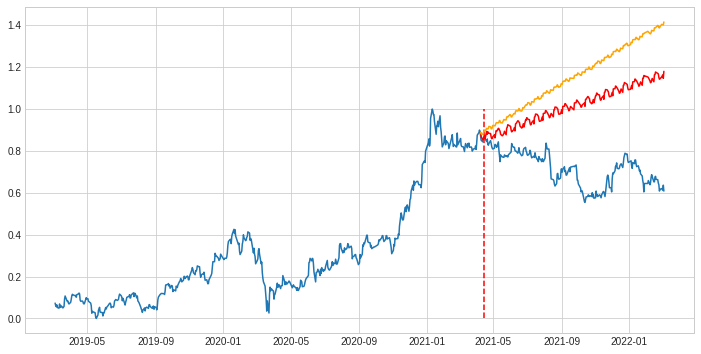

In [ ]:
fig, ax= plt.subplots(figsize=(12,6))
ax.plot(data.index, data.Close)
ax.vlines(pd.to_datetime('2021-04-15'), 0,1, linestyle ='--', color='r',
         label = 'Start of  Forcast')
ax.plot(predict_index_Arima, predicted_value_Arima, color='red', label='Arima prediction')
ax.plot(predict_index, predicted_value, color='orange', label='Sarima prediction')
ax.plot(predict_rnn, pred_y, color='blue', label='predicted SEC stock price')

#ax.fill_between(predict_index, predicted_lb, prediction_ub, color='k',
 #              alpha= 0.1, label='0.95 prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optimal[0][0][0], optimal[0][0][1]} prediction results (r2score: {round(r2,2)})')
plt.show()

In [ ]:
len(pred_y)

In [ ]:





dfy.iloc[:,-221:]

In [ ]:
df1

In [ ]:
len(predicted_value)

In [ ]:
len(pred_y)

In [ ]:
pred_y[-1]

In [ ]:
pred_y